# Vision Project Walkthrough

In [23]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transformC
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
#imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

#### Read data from a directory

In [24]:
path = '../my_test_data/IMG/*'
Img_list = glob.glob(path)
Img_list

['../my_test_data/IMG/robocam_2022_12_06_16_14_03_297.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_43_799.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_06_076.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_31_761.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_16_915.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_14_57_499.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_41_657.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_14_49_233.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_19_776.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_14_07_089.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_14_26_852.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_14_32_891.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_53_280.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_32_554.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_15_37_529.jpg',
 '../my_test_data/IMG/robocam_2022_12_06_16_14_10_363.jpg',
 '../my_test_data/IMG/robocam_2022_12_06

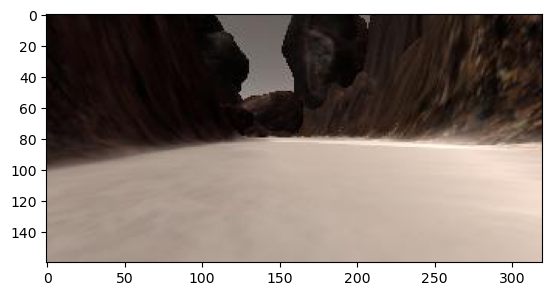

In [25]:
path = '../my_test_data/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Reading data from specific file

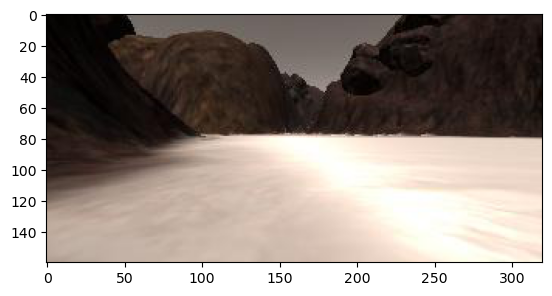

In [38]:
path = '../images_of_interest/*'
Img_list = glob.glob(path)
Img_list


image = mpimg.imread(Img_list[1])
plt.imshow(image)

---
---

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

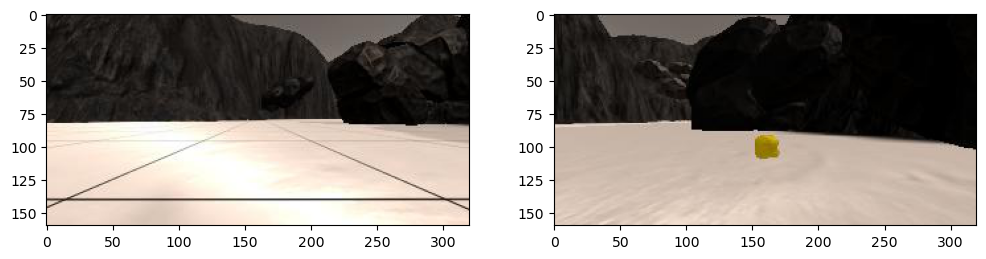

In [26]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
# read images from specified path
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

# Find Rocks Function

Text(0.5, 1.0, 'thresholded rock image')

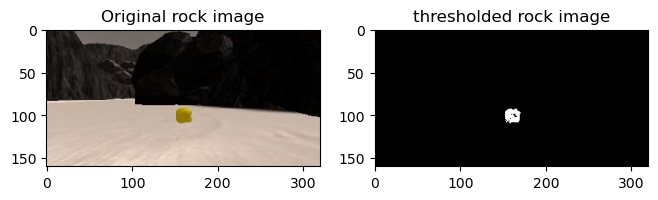

In [27]:
def find_rocks(img, thresh = (110,110,50)):
    rock_pixels = ((img[:,:,0]>thresh[0])\
                  &(img[:,:,1]>thresh[1])\
                  &(img[:,:,2]<thresh[2]))
    colored_pixels = np.zeros_like(img[:,:,0])
    colored_pixels[rock_pixels] = 1
    return colored_pixels

rockThesholded = find_rocks(rock_img)
# Do some plotting
fig = plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(rock_img)
plt.gca().set_title('Original rock image')
plt.subplot(132)
plt.imshow(rockThesholded, cmap='gray')
plt.gca().set_title('thresholded rock image')

---
---

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

(160, 320, 3)
(160, 320)


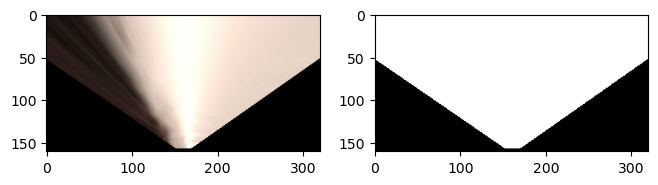

In [39]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))  # keep same size as input image
    ''' To improve the mapping precision we create this mask so that after the perspective transform and color thresh
        we could deduce the obstacles by subtracting the threshed from this mask'''
    mask = cv2.warpPerspective(np.ones_like(img[:, :, 0]), M, (img.shape[1], img.shape[0]))

    return warped, mask

#There is a catch you need to choose the parameters such that you map 1 pixel to 1 meter in the world map

dst = 10
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])


warped , mask = perspect_transform(image, source, destination)
m, n = mask.shape
for i in range(0,m):
    for j in range(0,n):
        if mask[i,j] > 0:
            mask[i,j] =1
        else:
            mask[i,j] =0


print(warped.shape)
print(mask.shape)

fig = plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(warped)
plt.subplot(132)
plt.imshow(mask, cmap='gray')

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

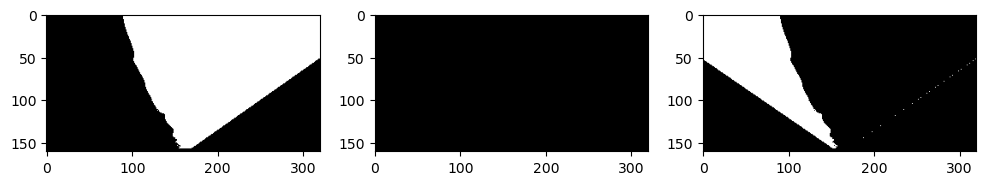

In [40]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] > rgb_thresh[0]) \
                  &(img[:,:, 1] > rgb_thresh[1]) \
                  &(img[:,:, 2] > rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def color_thresh_rock(img, rgb_thresh=(120, 120, 50)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] > rgb_thresh[0]) \
                  &(img[:,:, 1] > rgb_thresh[1]) \
                  &(img[:,:, 2] < rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped,(180,180,160))
obstacle_map = np.absolute(np.float32(threshed) - 1) * mask
rock = color_thresh_rock(warped,(120,120,50))
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(threshed, cmap='gray')
plt.subplot(132)
plt.imshow(rock, cmap='gray')
plt.subplot(133)
plt.imshow(obstacle_map, cmap='gray')

## Limit the view for better mapping

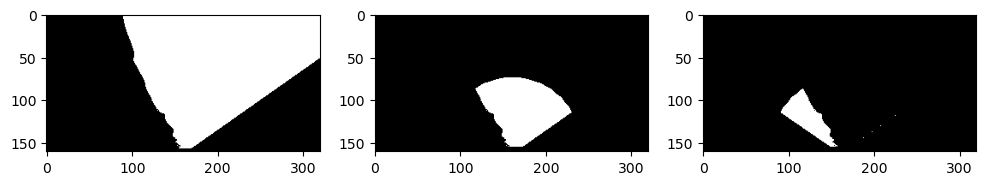

In [41]:
def trim_ellipse(image, offset, limit):
    # create a mask image of the same shape as input image, filled with 0s (black color)
    mask = np.zeros_like(image)
    rows, cols = mask.shape
    # create a white filled ellipse  ----------> 3/4
    mask = cv2.ellipse(mask, center=(int(cols / 2), int(rows-offset)), axes=(limit, limit), angle=0,
                       startAngle=180, endAngle=360, color=(255, 255, 255), thickness=-1)
    # Bitwise AND operation to black out regions outside the mask
    return image* mask



trimed_terrain = trim_ellipse(threshed, 6, 80)
trimed_obstacle = trim_ellipse(obstacle_map, 6, 80)

fig = plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(threshed, cmap='gray')
plt.subplot(132)
plt.imshow(trimed_terrain, cmap='gray')
plt.subplot(133)
plt.imshow(trimed_obstacle, cmap='gray')
plt.show()

# Adjust to world Coordinates

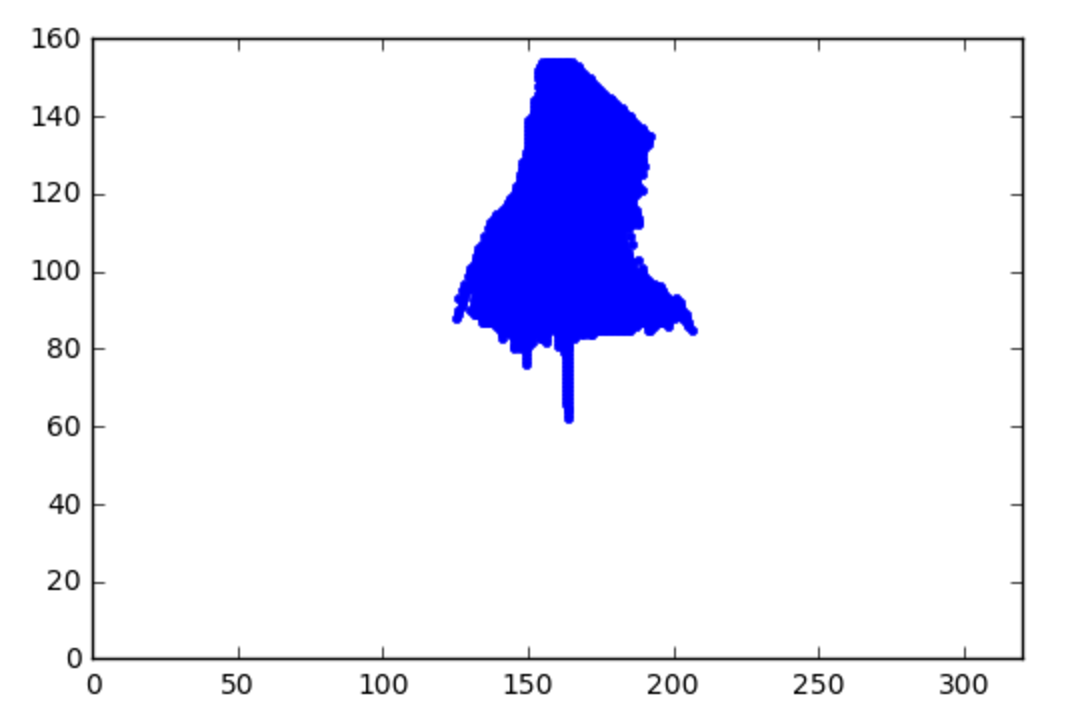

## World Map

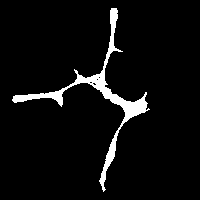

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

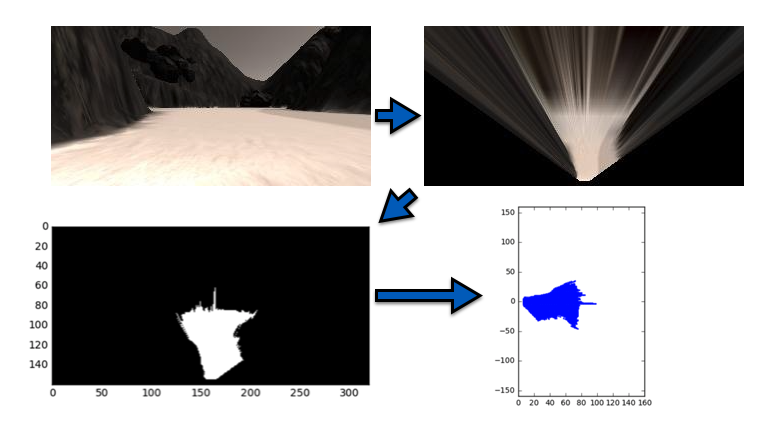

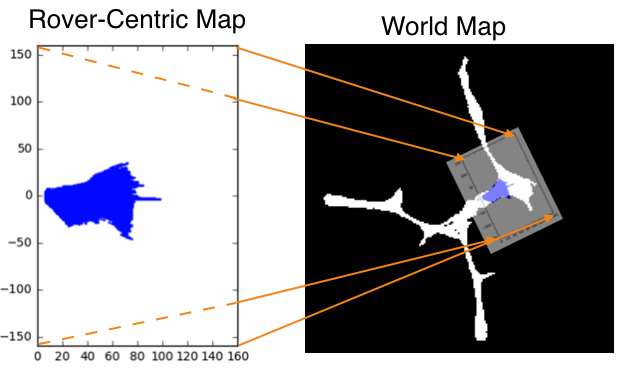

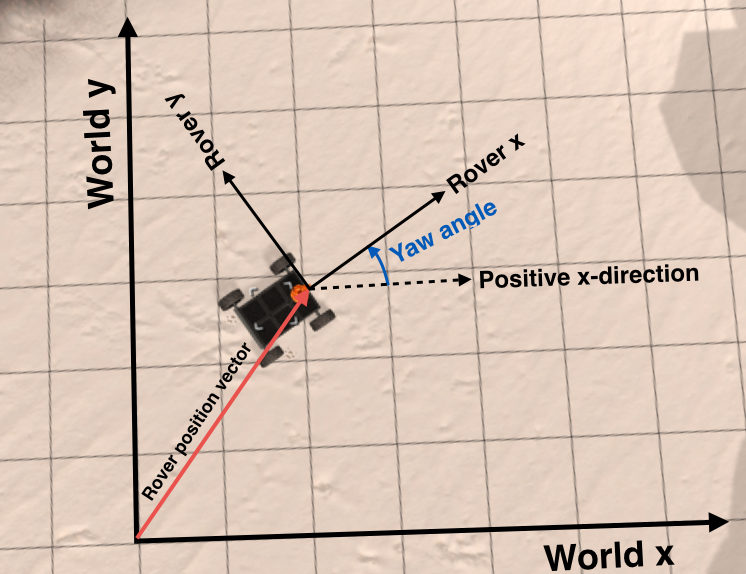

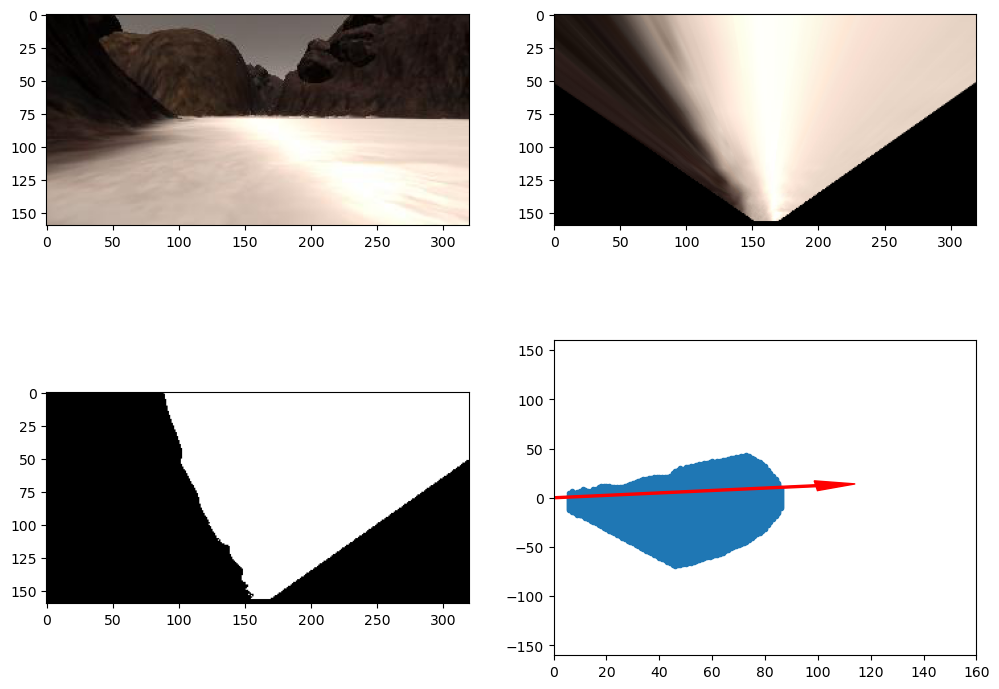

In [47]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float32) # something is wrong
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling -> yet to be done
    # Apply a translation
    xpix_translated = (xpix_rot) + xpos
    ypix_translated = (ypix_rot) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation

    return x_pix_world, y_pix_world


# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(trimed_terrain)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)
stand_dev = np.std(angles)
nav_dir = mean_dir + 0.8 * stand_dev
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(nav_dir)
y_arrow = arrow_length * np.sin(nav_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)